# Neighborhood Analysis for Real Estate Investing in Rome
### IBM Data Science Professional Certificate Capstone Project by Katarzyna Anna Parys

## Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussion](#Discussion)
* [Conclusion](#Conclusion)

# Introduction <a name="Introduction"></a>

This an IBM Data Science Professional Certificate Capstone Project, focused on real estate prices in Rome, Italy's capital and largest city, with 2,822,981 residents, as on December 31, 2020,  and the third most populous city in Europe, after Berlin and Madrid, if the areas within city administrative boundaries are considered.
Rome is topping also the list of the most popular European tourist cities. In fact, according to the data compiled by the Italian National Institute of Statistics (Istat), Rome reached 24.5 million of overnight stays in 2019. These numbers dropped drastically during the Covid-19 pandemic, but they are bound to increase as soon as the emergency is over. 
On the other hand, the Rome’s housing market remains steady, despite the pandemic-induced recession. During the year to February 2021, homes prices stood at €2,848 (US$3,404) per sq. m., on average, in February 2021, up 0.6% from a year earlier (unchanged when adjusted for inflation). 
The prices of the properties for sale may vary considerably across the city's neighborhoods. As of June 2021, house prices in Piazza di Spagna can fetch 9,100 euros per square meter, while in the Castelverde suburbs the average price for a residential property is around 1,600 euros per square meter. However, the distance from the city center isn't the only factor influencing property prices. 

## Business Problem <a name="businessproblem"></a>

The project aims at understanding the main factors determining house prices in Rome. The characteristics affecting property prices might include the distance from the city center, the density of population, the presence of different kinds of venues, like such as number of shops, restaurants, professional buildings, museums, universities, cafes, hotels, gyms and more, the traffic, the percentage of the foreign-born population. Such data gathered from Foursquare and other open sources will be used to cluster the 154 neighborhoods of Rome and understand the relationship between the price and the location of a property.

Knowing which characteristics of a neighborhood affect property prices in a given area could be useful for all participants in real estate markets, especially investors, to understand and predict property price trends. In particular, the Department of the Treasury of the Ministry of Economy and Finance, which manages the public sector real estate in Italy, could benefit from the project for a better property valuation and more efficient management.

## Data <a name="Data"></a>

The table below reports the type of data needed and their sources.

| Data | Source | Last updated |
| --- | --- | --- |
| List of prices per square meter to buy apartament in neighborhoods of Rome, Italy | https://www.immobiliare.it/mercato-immobiliare/lazio/roma/ | Daily updates |
|List of the neighborhoods (urban zones) | https://www.comune.roma.it/web-resources/cms/documents/Elenco_Z_Urbanistiche_rg_A.pdf | 2019 |
| Area of the urban zones| https://www.comune.roma.it/web/it/roma-statistica-territorio.page | 31.12.2019 |
| Population of the urban zones| https://www.comune.roma.it/web/it/roma-statistica-popolazione1.page | 31.12.2020 |
| Foreign population of the urban zones| https://www.comune.roma.it/web/it/roma-statistica-popolazione1.page | 31.12.2020 |
| Top 100 venues in a 1000 meters range of the centre of each urban zone, categorized by high-level groups | FourSquare API | Daily updates |
| Pollution levels (as a rough indicator of traffic) | http://www.arpalazio.net/main/aria/sci/basedati/bollettini/2021/BA192021.pdf| 16.05.2021 |
| List of the air monitoring stations in Rome with coordinates | http://dati.lazio.it/catalog/it/dataset/rete-di-monitoraggio-della-qualita-dell-aria/resource/0c9d32b8-06ed-4bb0-8727-9954c6d703f2| 2020 |


### Necessary imports and installations

In [1]:

# installing geocoder, geopy and folium
!pip3 install geocoder --user
!pip3 install geopy --user
!pip3 install folium --user
!pip install openpyxl --user
!pip install --ignore-installed beautifulsoup4
!pip install --ignore-installed matplotlib
!pip install --ignore-installed sklearn
# importing pandas and numpy for data manipulation
import numpy as np
import pandas as pd

# importing openpyxl for reading Excel files
import openpyxl

# importing requests for web page retrieval
import requests

# importing Beautiful soup for web page parsing
from bs4 import BeautifulSoup as BS

# importing matplotlib for map colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# importing math for NaN processing
import math

# importing geocoder, Nominatim and folium for map generation
import geocoder 
from geopy.geocoders import Nominatim 
import folium

# importing KMeans for clustering
from sklearn.cluster import KMeans

  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached soupsieve-2.2.1-py3-none-any.whl (33 kB)
  Using cached matplotlib-3.4.2-cp39-cp39-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached Pillow-8.2.0-cp39-cp39-macosx_10_10_x86_64.whl (2.8 MB)
  Using cached kiwisolver-1.3.1-cp39-cp39-macosx_10_9_x86_64.whl (61 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached numpy-1.20.3-cp39-cp39-macosx_10_9_x86_64.whl (16.1 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-0.24.2-cp39-cp39-macosx_10_13_x86_64.whl (7.3 MB)
  Using cached numpy-1.20.3-cp39-cp39-macosx_10_9_x86_64.whl (16.1 MB)
  Using cached scipy-1.6.3-cp39-cp39-macosx_10_9_x86_64.whl (30.9 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0

# Methodology  <a name="Methodology"></a>

First the data will be loaded and cleaned. Then for each urban zone, the geographical coordinates will be derived from the address of each zone's centre. The latitude and the longitude will than be used to retrieve the FourSquare data and venues. The match with the pollution data will be done on the basis of the locations of the air monitoring stations (12 in the city of Rome), using a closest distance function on longitude and latitude for joining tables.
The above data will be collected in a single dataframe, with a row for each urban zone and columns reporting population, density, pollution and a set of FourSquare categories with the number of top venues occurring for each category.
The features will be standardized for better manipulation of the clustering algorithm, and then a K-means clustering will be performed, with k determined by the elbow method.
The clusters will then be analized, using both tables and maps, looking for the correlations between clusters and price categories of the real estates.

### Data loading and cleaning

Scraping the real estate prices from https://www.immobiliare.it/mercato-immobiliare/lazio/roma/

In [2]:
#loading real estate data from the web page

# source url
url = "https://www.immobiliare.it/mercato-immobiliare/lazio/roma/"

# performing the request
file = requests.get(url).text

Parsing the text with BeautifulSoup to retrieve the table

In [3]:
# parsing data with Beautiful Soup
parsable_file = BS(file, 'lxml')

# retrieving the table
data_table_list = parsable_file.find_all('table')
data_table = data_table_list

Converting the table into a list

In [4]:
# converting the table into a list
list = pd.read_html(str(data_table), header=0)
list

[                                                 Zone  Vendita (€/m²)  \
 0                                      Centro Storico           7.406   
 1               Prati, Borgo, Mazzini, Delle Vittorie           4.985   
 2                                   Parioli, Flaminio           5.380   
 3                                    Salario, Trieste           4.701   
 4                               Testaccio, Trastevere           5.396   
 5   Corso Francia, Vigna Clara, Fleming, Ponte Milvio           4.290   
 6                                 Termini, Repubblica           4.053   
 7                            Re di Roma, San Giovanni           3.976   
 8                       Aventino, San Saba, Caracalla           6.295   
 9                                Bologna, Policlinico           4.365   
 10                           Eur, Torrino, Tintoretto           3.547   
 11                Pigneto, San Lorenzo, Casal Bertone           3.138   
 12                         Appio Lati

Converting the list into a dataframe

In [5]:
# converting the list into a dataframe
df_prices = list[0]
df_prices.head(51)

,Zone,Vendita (€/m²),Affitto (€/m²)
0,Centro Storico,7.406,2030
1,"Prati, Borgo, Mazzini, Delle Vittorie",4.985,1640
2,"Parioli, Flaminio",5.380,1680
3,"Salario, Trieste",4.701,1540
4,"Testaccio, Trastevere",5.396,1750
5,"Corso Francia, Vigna Clara, Fleming, Ponte Milvio",4.290,1510
6,"Termini, Repubblica",4.053,1630
7,"Re di Roma, San Giovanni",3.976,1430
8,"Aventino, San Saba, Caracalla",6.295,1940
9,"Bologna, Policlinico",4.365,1510


In [6]:
df_prices['Affitto (€/m²)']=df_prices['Affitto (€/m²)']/100
df_prices.head(150)

,Zone,Vendita (€/m²),Affitto (€/m²)
0,Centro Storico,7.406,20.3
1,"Prati, Borgo, Mazzini, Delle Vittorie",4.985,16.4
2,"Parioli, Flaminio",5.380,16.8
3,"Salario, Trieste",4.701,15.4
4,"Testaccio, Trastevere",5.396,17.5
5,"Corso Francia, Vigna Clara, Fleming, Ponte Milvio",4.290,15.1
6,"Termini, Repubblica",4.053,16.3
7,"Re di Roma, San Giovanni",3.976,14.3
8,"Aventino, San Saba, Caracalla",6.295,19.4
9,"Bologna, Policlinico",4.365,15.1


Rename the columns of the dataframe


In [7]:
# create a dictionary
# key = old name
# value = new name
dict = {'Zone': 'Zona Immobiliare',
        'Vendita (€/m²)': 'PurchasePrice/sqm',
        'Affitto (€/m²)': 'RentalPrice/sqm'}
  
# call rename () method
df_prices.rename(columns=dict,
          inplace=True)
df_prices_new=df_prices
df_prices_new['PurchasePrice/sqm']=df_prices_new['PurchasePrice/sqm'].astype(str).str.replace('\.','')
df_prices_new.head(51)

<ipython-input-7-c1b5bcb7ce7a>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_prices_new['PurchasePrice/sqm']=df_prices_new['PurchasePrice/sqm'].astype(str).str.replace('\.','')


,Zona Immobiliare,PurchasePrice/sqm,RentalPrice/sqm
0,Centro Storico,7406,20.3
1,"Prati, Borgo, Mazzini, Delle Vittorie",4985,16.4
2,"Parioli, Flaminio",538,16.8
3,"Salario, Trieste",4701,15.4
4,"Testaccio, Trastevere",5396,17.5
5,"Corso Francia, Vigna Clara, Fleming, Ponte Milvio",429,15.1
6,"Termini, Repubblica",4053,16.3
7,"Re di Roma, San Giovanni",3976,14.3
8,"Aventino, San Saba, Caracalla",6295,19.4
9,"Bologna, Policlinico",4365,15.1


In [9]:
# saving prices to excel
df_prices_new.to_excel(r'prices.xlsx', index = False)

Loading Rome neighborhoods, population and density from excel

In [10]:
#loading neighborhoods, population and density from excel

# source filepath
filepath = "UrbanZonesRome.xls"

# populating the dataframe
df_zones = pd.read_excel(filepath)

df_zones


,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,Address
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,Piazza della Rotonda
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,Piazza di San Cosimato
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,Viale Aventino
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,Via Nicola Zabaglia
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,Piazza Vittorio Emanuele II
...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,Via Entratico
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,Via Mastro Gabriello
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,Via della Stazione di Cesano
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,Via di Polline


In [11]:
# saving zones to excel
df_zones.to_excel(r'zones.xlsx', index = False)

Adding location of air monitoring stations

In [12]:
#loading the csv file with air monitoring stations and their coordinates

# source filepath
filepath = "stations.xls"

# populating the dataframe
df_stations = pd.read_excel(filepath)

df_stations.head()



,Station Code,Province,City,Name,Latitude,Longitude
0,2,Roma,Roma,Preneste,41.886019,12.541618
1,3,Roma,Roma,Francia,41.947448,12.469563
2,5,Roma,Roma,Magna Grecia,41.883075,12.508950
3,8,Roma,Roma,Cinecitta,41.857716,12.568652
4,10,Roma,Colleferro,Colleferro-Oberdan,41.730447,13.004056


Dropping useless rows and columns and giving the dataframe stations its final shape

In [13]:
# dropping the column "Province"
df_stations = df_stations.drop('Province', axis=1)

df_stations.head()


,Station Code,City,Name,Latitude,Longitude
0,2,Roma,Preneste,41.886019,12.541618
1,3,Roma,Francia,41.947448,12.469563
2,5,Roma,Magna Grecia,41.883075,12.508950
3,8,Roma,Cinecitta,41.857716,12.568652
4,10,Colleferro,Colleferro-Oberdan,41.730447,13.004056


In [17]:
# dropping the rows non regarding Rome

# Get indexes where name column doesn't have value "Roma"
indexNames = df_stations[~(df_stations['City'] == 'Roma')].index 

# Delete these row indexes from dataFrame
df_stations.drop(indexNames , inplace=True)
df_stations.reset_index(drop=True, inplace=True)
df_stations.rename(columns = {'Station Code':'StationCode'}, inplace = True)
df_stations.head(20)

,StationCode,City,Name,Latitude,Longitude
0,2,Roma,Preneste,41.886019,12.541618
1,3,Roma,Francia,41.947448,12.469563
2,5,Roma,Magna Grecia,41.883075,12.508950
3,8,Roma,Cinecitta,41.857716,12.568652
4,39,Roma,Villa Ada,41.932892,12.506947
5,40,Roma,Castel di Guido,41.889451,12.266327
6,41,Roma,Cavaliere,41.929474,12.658480
7,47,Roma,Fermi,41.863993,12.469570
8,48,Roma,Bufalotta,41.947654,12.533667
9,49,Roma,Cipro,41.906356,12.447588


In [18]:
# saving stations to excel
df_stations.to_excel(r'stations.xlsx', index = False)

Loading pollution data for the stations

In [19]:
#loading pollution data from a xls file

# source filepath
filepath = "pollution.xls"

# populating the dataframe
df_poll = pd.read_excel(filepath)

df_poll.head(15)


,StationCode,StationName,DaysPM10above50,PeriodAverage10-16.05.2021
0,56,Arenula,4,23
1,2,Preneste,9,28
2,3,Francia,4,25
3,5,Magna Grecia,7,24
4,8,Cinecitta',4,25
5,39,Villa Ada,4,22
6,40,Guido,4,19
7,41,Cavaliere,4,24
8,47,Fermi,16,30
9,48,Bufalotta,8,27


In [20]:
merged_df = pd.merge(df_stations, df_poll, on='StationCode')
merged_df=merged_df.drop('StationName', 1)
merged_df

,StationCode,City,Name,Latitude,Longitude,DaysPM10above50,PeriodAverage10-16.05.2021
0,2,Roma,Preneste,41.886019,12.541618,9,28
1,3,Roma,Francia,41.947448,12.469563,4,25
2,5,Roma,Magna Grecia,41.883075,12.508950,7,24
3,8,Roma,Cinecitta,41.857716,12.568652,4,25
4,39,Roma,Villa Ada,41.932892,12.506947,4,22
5,40,Roma,Castel di Guido,41.889451,12.266327,4,19
6,41,Roma,Cavaliere,41.929474,12.658480,4,24
7,47,Roma,Fermi,41.863993,12.469570,16,30
8,48,Roma,Bufalotta,41.947654,12.533667,8,27
9,49,Roma,Cipro,41.906356,12.447588,4,24


In [21]:
# saving pollution data to excel
merged_df.to_excel(r'poll.xlsx', index = False)

## Finding coordinates and calculating the distance from the city center

Retrieving a list containing address (for control), Longitude and Latitude of the centre of each urban zone

In [22]:

# retrieving longitude and latitude of the center of each zone

# instantiating a geolocator
geolocator = Nominatim(user_agent="stat_explorer")
city = 'Roma'
count = 0
# retrieving data for each station
columns_list = []

for address in df_zones['Address']:
    complete_address = address + ',' + city
    # passing the location to the geolocator
    location = geolocator.geocode(complete_address)
    if location is None:
       location = geolocator.geocode(str(city))  
       print('city '+city)
    else: print('complete_address '+complete_address)
    # retrieving latitude and longitude from the geolocator
    
    
    print(location)
    print(count)
    count = count + 1
    latitude = location.latitude
    longitude = location.longitude
    display_name = location.address
    columns_list.append([latitude, longitude, complete_address])

columns_list

complete_address Piazza della Rotonda,Roma
Piazza della Rotonda, Rione III Colonna, Municipio Roma I, Roma, Roma Capitale, Lazio, Italia
0
complete_address Piazza di San Cosimato,Roma
Piazza di San Cosimato, Rione XIII Trastevere, Municipio Roma I, Roma, Roma Capitale, Lazio, 00153, Italia
1
complete_address Viale Aventino,Roma
Viale Aventino, Rione XII Ripa, Municipio Roma I, Roma, Roma Capitale, Lazio, 00184, Italia
2
complete_address Via Nicola Zabaglia,Roma
Via Nicola Zabaglia, Rione XX Testaccio, Municipio Roma I, Roma, Roma Capitale, Lazio, 00153, Italia
3
complete_address Piazza Vittorio Emanuele II,Roma
Piazza Vittorio Emanuele II, Municipio Roma I, Roma, Roma Capitale, Lazio, Italia
4
complete_address Via Sallustiana,Roma
Via Sallustiana, Rione XVII Sallustiano, Municipio Roma I, Roma, Roma Capitale, Lazio, 00187, Italia
5
complete_address Via Celimontana,Roma
Via Celimontana, Municipio Roma I, Roma, Roma Capitale, Lazio, 00184, Italia
6
complete_address Piazza di San Gregorio

complete_address Via Ciro Ferri,Roma
Via Ciro Ferri, Tor Bella Monaca, Zona XIII Torre Angela, Torre Angela, Roma, Roma Capitale, Lazio, 00133, Italia
62
complete_address Via Capaci,Roma
Via Capaci, Zona XIV Borghesiana, Finocchio, Roma, Roma Capitale, Lazio, 00132, Italia
63
complete_address Via Cantiano,Roma
Via Cantiano, Zona XI San Vittorino, Giardini di Corcolle, Roma, Roma Capitale, Lazio, 00011, Italia
64
complete_address Piazza Lugo,Roma
Piazza Lugo, Quartiere VIII Tuscolano, Roma, Roma Capitale, Lazio, Italia
65
complete_address Via Albano,Roma
Via Albano, Quartiere VIII Tuscolano, Roma, Roma Capitale, Lazio, 00179, Italia
66
complete_address Via Campo Barbarico,Roma
Via Campo Barbarico, Tor Fiscale, Quartiere VIII Tuscolano, Roma, Roma Capitale, Lazio, 00179, Italia
67
complete_address Piazza Tuscolo,Roma
Piazza Tuscolo, San Giovanni, Quartiere IX Appio-Latino, Roma, Roma Capitale, Lazio, Italia
68
complete_address Piazza Lazzaro Papi,Roma
Piazza Lazzaro Papi, Quartiere IX Ap

complete_address Viale dei Colli Portuensi,Roma
Viale dei Colli Portuensi, Quartiere XII Gianicolense, Roma, Roma Capitale, Lazio, 00152, Italia
120
complete_address Via di Bravetta,Roma
Via di Bravetta, Suburbio VIII Gianicolense, Roma, Roma Capitale, Lazio, 00164, Italia
121
complete_address Via degli Aldobrandeschi,Roma
Via degli Aldobrandeschi, Suburbio VIII Gianicolense, Roma, Roma Capitale, Lazio, 00163, Italia
122
complete_address Via di Donna Olimpia,Roma
Via di Donna Olimpia, Monteverde, Quartiere XII Gianicolense, Roma, Roma Capitale, Lazio, 00152, Italia
123
complete_address Via della Massimina,Roma
Massimina, Municipio Roma XII, Roma, Roma Capitale, Lazio, 00166, Italia
124
complete_address Vicolo del Casale Lumbroso,Roma
Vicolo del Casale Lumbroso, Casal Lumbroso, Municipio Roma XII, Roma, Roma Capitale, Lazio, 00163, Italia
125
complete_address Viale Vittoria Nenni,Roma
Viale Vittoria Nenni, Quartiere XII Gianicolense, Roma, Roma Capitale, Lazio, 00165, Italia
126
complet

[[41.89929, 12.4768694028846, 'Piazza della Rotonda,Roma'],
 [41.8878798, 12.4703757, 'Piazza di San Cosimato,Roma'],
 [41.884352, 12.4888594, 'Viale Aventino,Roma'],
 [41.8776613, 12.4757555, 'Via Nicola Zabaglia,Roma'],
 [41.8945791, 12.504323190904984, 'Piazza Vittorio Emanuele II,Roma'],
 [41.9077151, 12.4958006, 'Via Sallustiana,Roma'],
 [41.8885198, 12.4964896, 'Via Celimontana,Roma'],
 [41.8864509, 12.4902151, 'Piazza di San Gregorio,Roma'],
 [41.9068694, 12.4607383, 'Via Cola di Rienzo,Roma'],
 [41.91675635, 12.454911464956378, 'Piazzale Clodio,Roma'],
 [41.4601169, 12.6732482, 'Via Cipro, 8,Roma'],
 [41.9334447, 12.474887982249408, 'Piazza Jan Palach,Roma'],
 [41.9240132, 12.4846584, 'Via Giovanni Antonelli,Roma'],
 [41.9246825, 12.4656467, 'Via Raffaele Stern,Roma'],
 [41.91809215, 12.500170113170537, 'Piazza Buenos Aires,Roma'],
 [41.928481, 12.5137131, 'Via Lucrino, 00100,Roma'],
 [41.91432365, 12.483789307180054, 'Villa Borghese,Roma'],
 [41.9372333, 12.4914499, 'Largo Giu

Transforming the retrieved list in dataframe

In [23]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['latitude', 'longitude', 'address']
columns_df.head()

,latitude,longitude,address
0,41.899290,12.476869,"Piazza della Rotonda,Roma"
1,41.887880,12.470376,"Piazza di San Cosimato,Roma"
2,41.884352,12.488859,"Viale Aventino,Roma"
3,41.877661,12.475755,"Via Nicola Zabaglia,Roma"
4,41.894579,12.504323,"Piazza Vittorio Emanuele II,Roma"


Adding coordinates to the original table

In [24]:
df_zones_coord = pd.concat([df_zones, columns_df], axis=1, sort=False)
df_zones_coord.head(155)

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,Address,latitude,longitude,address
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,Piazza della Rotonda,41.899290,12.476869,"Piazza della Rotonda,Roma"
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,Piazza di San Cosimato,41.887880,12.470376,"Piazza di San Cosimato,Roma"
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,Viale Aventino,41.884352,12.488859,"Viale Aventino,Roma"
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,Via Nicola Zabaglia,41.877661,12.475755,"Via Nicola Zabaglia,Roma"
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,Piazza Vittorio Emanuele II,41.894579,12.504323,"Piazza Vittorio Emanuele II,Roma"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,Via Entratico,42.032778,12.475760,"Via Entratico,Roma"
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,Via Mastro Gabriello,41.991476,12.486742,"Via Mastro Gabriello,Roma"
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,Via della Stazione di Cesano,42.062431,12.327062,"Via della Stazione di Cesano,Roma"
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,Via di Polline,42.123512,12.289188,"Via di Polline,Roma"


Removing all un-necessary columns

In [25]:
df_zones_coord = df_zones_coord.drop('address', axis = 1)
df_zones_coord.head(200)
                                      

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,Address,latitude,longitude
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,Piazza della Rotonda,41.899290,12.476869
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,Piazza di San Cosimato,41.887880,12.470376
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,Viale Aventino,41.884352,12.488859
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,Via Nicola Zabaglia,41.877661,12.475755
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,Piazza Vittorio Emanuele II,41.894579,12.504323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,Via Entratico,42.032778,12.475760
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,Via Mastro Gabriello,41.991476,12.486742
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,Via della Stazione di Cesano,42.062431,12.327062
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,Via di Polline,42.123512,12.289188


In [311]:
# saving zones_coord data to excel
df_zones_coord.to_excel(r'zones_coord.xlsx', index = False)

In [26]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat2 = 41.899290
    lon2 = 12.476869
    print("lon1 "+str(lon1))
    print("lat1"+str(lat1))
    print(type(lat2))
    print(type(lon1))
    print(type(lat1))
    print(type(lon2))
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1[1], lat1[1], lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


In [27]:
def linear_distance(lat1, lon1):
    lat2=41.899290
    lon2=12.476869
    distance=np.sqrt(((lat1-lat2)**2+(lon1-lon2)**2))
    print("Distance: "+str(distance))
    return np.round(distance, 2)

In [28]:
df_zones_coord["distance"] = df_zones_coord.apply(lambda row: linear_distance(row['latitude'],row['longitude']), axis=1)

Distance: 4.0288459857151793e-07
Distance: 0.01312842751170204
Distance: 0.01915498723988162
Distance: 0.021657343926253687
Distance: 0.027855433528438306
Distance: 0.020721674366950882
Distance: 0.02238225083408849
Distance: 0.018519202845155392
Distance: 0.017822648143584276
Distance: 0.028057204556305688
Distance: 0.4810798290889442
Distance: 0.03421210258692527
Distance: 0.025921253260593795
Distance: 0.027761827633283095
Distance: 0.029940987285134647
Distance: 0.047006405795485165
Distance: 0.016549963256417718
Distance: 0.04064845211936256
Distance: 0.045761273954294544
Distance: 0.037846630780823114
Distance: 0.036532171471866805
Distance: 0.043701577914303194
Distance: 0.07183066859621864
Distance: 0.07293712996581232
Distance: 0.08685858527618164
Distance: 0.08403495806210574
Distance: 0.07934030672142373
Distance: 0.09884302566215533
Distance: 0.062017747102742556
Distance: 0.06159620105566635
Distance: 0.07431564253432525
Distance: 0.07556225865404015
Distance: 0.1155565241

In [29]:
df_zones_coord

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,Address,latitude,longitude,distance
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,Piazza della Rotonda,41.899290,12.476869,0.00
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,Piazza di San Cosimato,41.887880,12.470376,0.01
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,Viale Aventino,41.884352,12.488859,0.02
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,Via Nicola Zabaglia,41.877661,12.475755,0.02
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,Piazza Vittorio Emanuele II,41.894579,12.504323,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,Via Entratico,42.032778,12.475760,0.13
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,Via Mastro Gabriello,41.991476,12.486742,0.09
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,Via della Stazione di Cesano,42.062431,12.327062,0.22
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,Via di Polline,42.123512,12.289188,0.29


Merging together zones and pollution

In [30]:
# assigning the correct pollution to each zone using latitude and longitude

# importing the geopy function calculating distance of two points given the coordinates
import geopy.distance

# maximum distance between points on Earth
max_distance = 20000

# this function returns PM10 average and number of days above max level for given coordinates
def find_pollution(latitude, longitude):

    # zone coordinates
    stat_coord = (latitude, longitude)
    
    temp_distance = max_distance
    
    pollution = []
    
    for lat, long, pm10, bre in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['PeriodAverage10-16.05.2021'], merged_df['DaysPM10above50']):
        # pollution station coordinates
        poll_coord = (lat, long)
        # distance between points using geodesic formula
        distance = geopy.distance.geodesic(stat_coord, poll_coord).km
        if distance < temp_distance: 
            temp_distance = distance
            temp_PM10 = pm10
            temp_sforamenti = bre
    
    temp_PM10  
    temp_sforamenti
    
    return temp_PM10, temp_sforamenti


columns_list = []
count = 0

# finding the pollution for each zone
for latitude, longitude in zip(df_zones_coord['latitude'], df_zones_coord['longitude']):
    
    # finding the pollution values corresponding to the station
    pm10, overcoming = find_pollution(latitude, longitude)
   
    
    count = count + 1
    print(pm10)
    print(overcoming)
    print(latitude) 
    print(longitude) 
    columns_list.append([pm10, overcoming])

columns_list


23
4
41.89929
12.4768694028846
23
4
41.8878798
12.4703757
23
4
41.884352
12.4888594
30
16
41.8776613
12.4757555
24
7
41.8945791
12.504323190904984
23
4
41.9077151
12.4958006
24
7
41.8885198
12.4964896
23
4
41.8864509
12.4902151
24
4
41.9068694
12.4607383
24
4
41.91675635
12.454911464956378
25
4
41.4601169
12.6732482
25
4
41.9334447
12.474887982249408
22
4
41.9240132
12.4846584
24
4
41.9246825
12.4656467
22
4
41.91809215
12.500170113170537
22
4
41.928481
12.5137131
23
4
41.91432365
12.483789307180054
22
4
41.9372333
12.4914499
32
18
41.9133196
12.5204266
24
7
41.8968439
12.5146365
24
7
41.9047218
12.5129951
24
7
41.8985552
12.5205644
27
8
41.9412337
12.5351817
27
8
41.9532393
12.5259536
27
8
41.9462007
12.5499703
27
8
41.9739261
12.5154867
27
8
41.9675204
12.5173597
27
8
41.9618202
12.5534191
27
8
41.9419287
12.5219039
27
8
41.9353107
12.526835
27
8
41.9488048
12.5322865
27
8
41.9703389
12.5025927
27
8
42.0063554
12.5203467
27
8
41.9818555
12.5581982
27
8
41.9917348
12.5519439
32
18
41.

[[23, 4],
 [23, 4],
 [23, 4],
 [30, 16],
 [24, 7],
 [23, 4],
 [24, 7],
 [23, 4],
 [24, 4],
 [24, 4],
 [25, 4],
 [25, 4],
 [22, 4],
 [24, 4],
 [22, 4],
 [22, 4],
 [23, 4],
 [22, 4],
 [32, 18],
 [24, 7],
 [24, 7],
 [24, 7],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [27, 8],
 [32, 18],
 [32, 18],
 [32, 18],
 [32, 18],
 [27, 8],
 [32, 18],
 [32, 18],
 [27, 8],
 [24, 4],
 [24, 4],
 [28, 9],
 [28, 9],
 [28, 9],
 [28, 9],
 [28, 9],
 [25, 4],
 [32, 18],
 [24, 4],
 [28, 9],
 [25, 4],
 [28, 9],
 [32, 18],
 [25, 4],
 [25, 4],
 [25, 4],
 [24, 4],
 [24, 4],
 [25, 4],
 [24, 4],
 [24, 4],
 [24, 7],
 [28, 9],
 [25, 4],
 [24, 7],
 [24, 7],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [25, 4],
 [30, 16],
 [30, 16],
 [30, 16],
 [24, 7],
 [30, 16],
 [30, 16],
 [30, 16],
 [25, 4],
 [25, 4],
 [30, 16],
 [30, 16],
 [30, 16],
 [30, 16],
 [30, 16],
 [30, 16],
 [30, 16],
 [25, 4

Creating a dataframe from the list

In [31]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['PM10', 'overcomings']
columns_df

,PM10,overcomings
0,23,4
1,23,4
2,23,4
3,30,16
4,24,7
...,...,...
150,25,4
151,25,4
152,25,4
153,25,4


Adding data to the original table

In [96]:
df_zones_poll = pd.concat([df_zones_coord, columns_df], axis=1, sort=False)
df_zones_poll

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,Address,latitude,longitude,distance,PM10,overcomings
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,Piazza della Rotonda,41.899290,12.476869,0.00,23,4
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,Piazza di San Cosimato,41.887880,12.470376,0.01,23,4
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,Viale Aventino,41.884352,12.488859,0.02,23,4
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,Via Nicola Zabaglia,41.877661,12.475755,0.02,30,16
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,Piazza Vittorio Emanuele II,41.894579,12.504323,0.03,24,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,Via Entratico,42.032778,12.475760,0.13,25,4
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,Via Mastro Gabriello,41.991476,12.486742,0.09,25,4
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,Via della Stazione di Cesano,42.062431,12.327062,0.22,25,4
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,Via di Polline,42.123512,12.289188,0.29,25,4


## Adding FourSquare data

Extracting the venues for each zone, by category

Storing my FourSquare credentials in variables

In [174]:
# my foursquare credentials
CLIENT_ID = 'IGKJCSFYIYF1P2DNVXBW3AC1R00S1DQD455BE4LJJ4HEKCXA' # my Foursquare ID
CLIENT_SECRET = 'FZUCYEULUBVAJMAVQZEXGZTCDEGSMGPG4XFVO14X5INUMAXY' # my Foursquare Secret
#CLIENT_ID = 'IGKJCSFYIYF1P2DNVXBW3AC1R00S1DQD455BE4LJJ4HEKCXA' # my Foursquare ID
#CLIENT_SECRET = 'FZUCYEULUBVAJMAVQZEXGZTCDEGSMGPG4XFVO14X5INUMAXY' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: IGKJCSFYIYF1P2DNVXBW3AC1R00S1DQD455BE4LJJ4HEKCXA
CLIENT_SECRET:FZUCYEULUBVAJMAVQZEXGZTCDEGSMGPG4XFVO14X5INUMAXY


Retrieving the 10 high-level categories of venues

In [175]:
# building the url requesting all the categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

# executing the request
results = requests.get(categories_url).json()

number_high_categories = len(results['response']['categories'])
print('number of high-level categories: '+ str(number_high_categories))

number of high-level categories: 10


In [170]:
#inizializing the list
categories_list = []  

# storing the high-level categories into a list
for i in range(0,number_high_categories):
    id = results['response']['categories'][i]['id']
    name = results['response']['categories'][i]['name']
    print(id)
    print(name)
    categories_list.append([name, id])

#showing the list content
print(categories_list)

4d4b7104d754a06370d81259
Arts & Entertainment
4d4b7105d754a06372d81259
College & University
4d4b7105d754a06373d81259
Event
4d4b7105d754a06374d81259
Food
4d4b7105d754a06376d81259
Nightlife Spot
4d4b7105d754a06377d81259
Outdoors & Recreation
4d4b7105d754a06375d81259
Professional & Other Places
4e67e38e036454776db1fb3a
Residence
4d4b7105d754a06378d81259
Shop & Service
4d4b7105d754a06379d81259
Travel & Transport
[['Arts & Entertainment', '4d4b7104d754a06370d81259'], ['College & University', '4d4b7105d754a06372d81259'], ['Event', '4d4b7105d754a06373d81259'], ['Food', '4d4b7105d754a06374d81259'], ['Nightlife Spot', '4d4b7105d754a06376d81259'], ['Outdoors & Recreation', '4d4b7105d754a06377d81259'], ['Professional & Other Places', '4d4b7105d754a06375d81259'], ['Residence', '4e67e38e036454776db1fb3a'], ['Shop & Service', '4d4b7105d754a06378d81259'], ['Travel & Transport', '4d4b7105d754a06379d81259']]


Adding columns to the stations dataframe to store the venues data

In [176]:
df_zones_venues = df_zones_poll.copy()

# for each category, a new empty column is created
for categories in categories_list:
    # the empty column creation
    df_zones_venues[categories[0]] = 0
df_zones_venues

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,0,0,0,0,0,0,0,0,0,0
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,0,0,0,0,0,0,0,0,0,0
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,0,0,0,0,0,0,0,0,0,0
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,0,0,0,0,0,0,0,0,0,0
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,0,0,0,0,0,0,0,0
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,...,0,0,0,0,0,0,0,0,0,0
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,...,0,0,0,0,0,0,0,0,0,0
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,...,0,0,0,0,0,0,0,0,0,0


Retrieving the venues count for each zone

In [181]:
#  function returning the number of venues belonging to a category and close to the given lat and long
def get_total_venues_count(latitude, longitude, categoryId, radius):
    # latitude and longitude are joined in a single coordinates field
    latlong = str(latitude) + ',' + str(longitude)
    # the url is built
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            categoryId,
            LIMIT)
        
    # the request is executed, asking for the Results, that is the needed venues count
    results = requests.get(url).json()["response"]['groups'][0]['items']

In [ ]:
# retrieving the venues count
count = 1
for i,rows in df_zones_venues.iterrows():
    for category in categories_list:
        df_zones_venues.loc[i, category[0]] = get_total_venues_count(df_zones_venues.latitude.loc[i],df_zones_venues.longitude.loc[i], categoryId = category[0], radius = 1000)

In [45]:
df_zones_venues.head(155)

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,0,0,0,0,0,0,0,0,0,0
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,0,0,0,0,0,0,0,0,0,0
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,0,0,0,0,0,0,0,0,0,0
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,0,0,0,0,0,0,0,0,0,0
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,0,0,0,0,0,0,0,0
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,...,0,0,0,0,0,0,0,0,0,0
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,...,0,0,0,0,0,0,0,0,0,0
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,...,0,0,0,0,0,0,0,0,0,0


In [206]:
# saving the venues to excel
df_zones_venues.to_excel(r'zones_venues.xlsx', index = False)

Zones with full data are loaded and displayed

In [68]:
#loading zones from the excel

# source filepath
filepath = "zones_venues.xlsx"

# populating the dataframe
df_all = pd.read_excel(filepath)

df_all.head(200)

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,68,38,3,100,100,100,100,8,75,77
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,35,24,2,100,72,82,49,3,21,43
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,9,6,3,67,26,41,58,1,11,48
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,22,6,1,100,33,28,32,6,31,47
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,28,28,10,100,67,36,56,7,55,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,0,2,0,0,2,0,3,1
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,...,1,1,0,5,2,6,3,0,9,2
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,...,0,0,0,4,0,1,2,0,6,2
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,...,0,0,0,1,0,2,0,0,0,0


Add the distance column

In [110]:
df_all["distance"] = df_all.apply(lambda row: linear_distance(row['latitude'],row['longitude']), axis=1)

Distance: 4.0288459857151793e-07
Distance: 0.01312842751170204
Distance: 0.01915498723988162
Distance: 0.021657343926253687
Distance: 0.027855433528434802
Distance: 0.020721674366950882
Distance: 0.02238225083408849
Distance: 0.018519202845155392
Distance: 0.017822648143584276
Distance: 0.028057204556304297
Distance: 0.4810798290889442
Distance: 0.03421210258692517
Distance: 0.025921253260593795
Distance: 0.027761827633283095
Distance: 0.029940987285137412
Distance: 0.047006405795485165
Distance: 0.01654996325641623
Distance: 0.04064845211936256
Distance: 0.045761273954294544
Distance: 0.037846630780823114
Distance: 0.036532171471866805
Distance: 0.043701577914303194
Distance: 0.07183066859621864
Distance: 0.07293712996581232
Distance: 0.08685858527618164
Distance: 0.08403495806210574
Distance: 0.07934030672142373
Distance: 0.09884302566215533
Distance: 0.062017747102742556
Distance: 0.06159620105566635
Distance: 0.07431564253432525
Distance: 0.07556225865404015
Distance: 0.11555652415

Data structure is checked

In [111]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Zone                         155 non-null    object 
 1   Name                         155 non-null    object 
 2   Zona Immobiliare             155 non-null    object 
 3   District                     155 non-null    int64  
 4   Population 31.12.2019        155 non-null    int64  
 5   Population 31.12.2020        155 non-null    int64  
 6   Area                         155 non-null    float64
 7   Density                      155 non-null    int64  
 8   Foreigners 31.12.2020        155 non-null    int64  
 9   ForeignersPerc               155 non-null    int64  
 10  Address                      155 non-null    object 
 11  latitude                     155 non-null    float64
 12  longitude                    155 non-null    float64
 13  PM10                

Data statistic is explored

In [112]:
df_all.describe()

,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,latitude,longitude,PM10,...,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,7.625806,18014.412903,17857.825806,8.302452,5938.690323,2326.045161,14.600000,41.882476,12.491819,26.606452,...,5.800000,0.496774,24.858065,9.006452,10.819355,12.967742,2.387097,14.851613,10.735484,0.099742
std,4.344198,14996.030617,14839.490662,12.500734,5900.247441,2368.966500,8.356971,0.080070,0.086987,2.933233,...,10.771776,1.321030,29.670581,14.756683,13.845845,15.002346,2.675980,13.148400,17.251794,0.065910
min,1.000000,15.000000,15.000000,0.470000,2.000000,7.000000,4.000000,41.460117,12.254049,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,7152.500000,7000.000000,1.810000,770.000000,770.000000,9.000000,41.845618,12.439268,24.000000,...,1.000000,0.000000,5.000000,2.000000,3.000000,4.000000,0.000000,5.000000,2.000000,0.050000
50%,7.000000,14538.000000,14663.000000,3.190000,4806.000000,1711.000000,12.000000,41.887880,12.495801,25.000000,...,3.000000,0.000000,10.000000,4.000000,6.000000,7.000000,2.000000,10.000000,4.000000,0.090000
75%,11.000000,26770.500000,26470.500000,8.300000,8319.000000,3285.000000,17.000000,41.926837,12.551772,30.000000,...,5.500000,0.000000,34.500000,7.000000,13.500000,17.000000,4.000000,21.500000,9.000000,0.130000
max,15.000000,87397.000000,86531.000000,61.490000,25449.000000,15914.000000,58.000000,42.123512,12.730180,32.000000,...,73.000000,10.000000,100.000000,100.000000,100.000000,100.000000,13.000000,75.000000,90.000000,0.480000


In [275]:
# saving df_all to excel
df_all.to_excel(r'all.xlsx', index = False)

In [290]:
#loading df_all from excel

# source filepath
filepath = "all.xlsx"

# populating the dataframe
df_all = pd.read_excel(filepath)
df_all

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,38,3,100,100,100,100,8,75,77,0.001
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,24,2,100,72,82,49,3,21,43,0.010
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,6,3,67,26,41,58,1,11,48,0.020
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,6,1,100,33,28,32,6,31,47,0.020
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,28,10,100,67,36,56,7,55,90,0.030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,2,0,0,2,0,3,1,0.130
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,...,1,0,5,2,6,3,0,9,2,0.090
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,...,0,0,4,0,1,2,0,6,2,0.220
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,...,0,0,1,0,2,0,0,0,0,0.290


## Exploratory data analysis

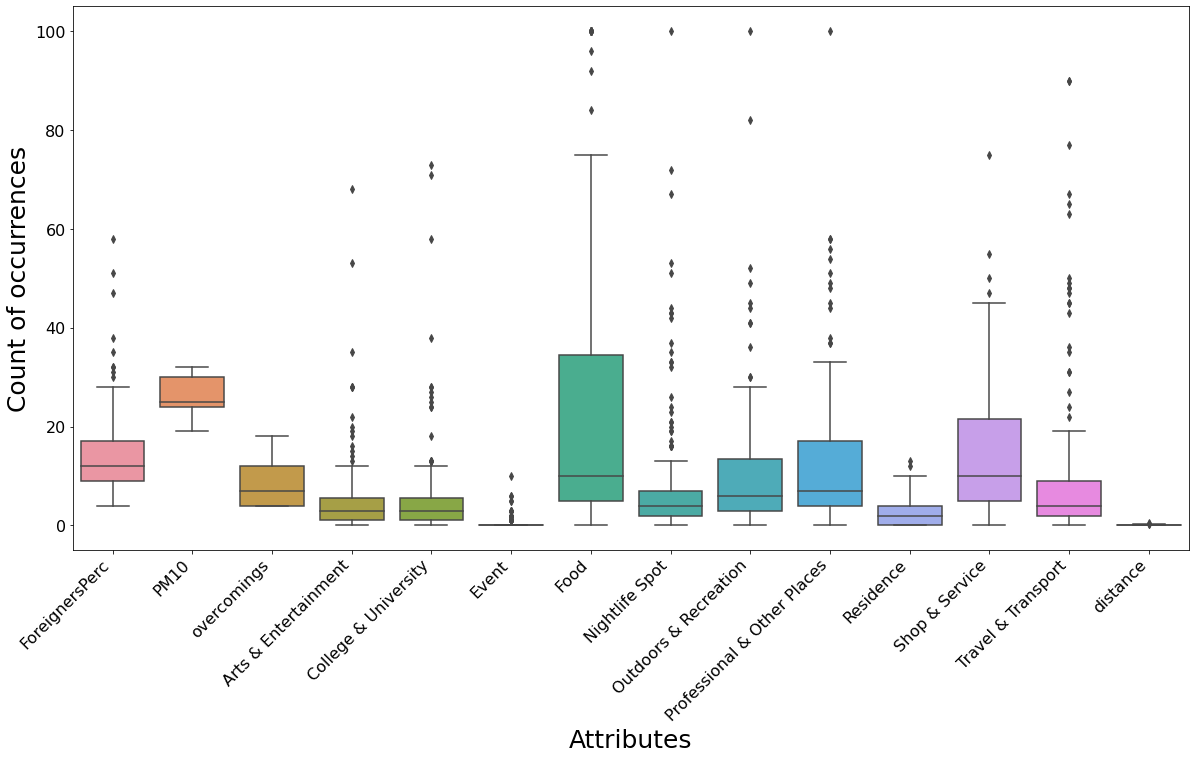

In [278]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

df_all_copy = df_all.drop(['Zone', 'Name', 'Zona Immobiliare', 'Area','District','Population 31.12.2019','Population 31.12.2020', 'Density','Foreigners 31.12.2020', 'Address', 'latitude','longitude'], axis=1)
ax = sns.boxplot(data = df_all_copy)
ax.set_ylabel('Count of occurrences', fontsize=25)
ax.set_xlabel('Attributes', fontsize=25)
ax.tick_params(labelsize=16)
plt.xticks(rotation=45, ha='right')

plt.show()

The most represented venues are Food, Shops and Professional and all venues present significant upper outliers. PM10 and overcomings are more evenly distributed.

## Data normalization

The data is now normalized as a preparation for clustering.

In [279]:
# importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# keeping numerical and independent variables columns only
df_all_num = df_all.drop(['Zone', 'Name', 'Zona Immobiliare', 'Area','District','Population 31.12.2019','Foreigners 31.12.2020', 'Address', 'longitude', 'latitude'], axis=1)

#getting the values to be standardized (excluding name and category)
X = df_all_num.values
# applying scaler
scaled_dataset = MinMaxScaler().fit_transform(X)

In [280]:
scaled_dataset

array([[2.73683481e-01, 2.91782921e-01, 4.25925926e-01, ...,
        1.00000000e+00, 8.55555556e-01, 0.00000000e+00],
       [1.55254519e-01, 2.91861516e-01, 4.44444444e-01, ...,
        2.80000000e-01, 4.77777778e-01, 1.87891441e-02],
       [9.51962643e-02, 2.07765159e-01, 3.14814815e-01, ...,
        1.46666667e-01, 5.33333333e-01, 3.96659708e-02],
       ...,
       [1.25930464e-01, 1.02959091e-02, 3.70370370e-01, ...,
        8.00000000e-02, 2.22222222e-02, 4.57202505e-01],
       [4.27666559e-04, 1.17892089e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.03340292e-01],
       [7.10851172e-03, 1.24965615e-02, 3.14814815e-01, ...,
        5.33333333e-02, 2.22222222e-02, 1.02296451e-01]])

In [281]:
# transforming the scaled dataset in dataframe
scaled_dataframe = pd.DataFrame(scaled_dataset)
# setting the column names again
scaled_dataframe.columns = ['Population 31.12.2020', 'Density','ForeignersPerc','PM10','overcomings','distance']+[category[0] for category in categories_list]
scaled_dataframe.head()

,Population 31.12.2020,Density,ForeignersPerc,PM10,overcomings,distance,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.273683,0.291783,0.425926,0.307692,0.000000,1.000000,0.520548,0.3,1.00,1.00,1.00,1.00,0.615385,1.000000,0.855556,0.000000
1,0.155255,0.291862,0.444444,0.307692,0.000000,0.514706,0.328767,0.2,1.00,0.72,0.82,0.49,0.230769,0.280000,0.477778,0.018789
2,0.095196,0.207765,0.314815,0.307692,0.000000,0.132353,0.082192,0.3,0.67,0.26,0.41,0.58,0.076923,0.146667,0.533333,0.039666
3,0.088492,0.463709,0.092593,0.846154,0.857143,0.323529,0.082192,0.1,1.00,0.33,0.28,0.32,0.461538,0.413333,0.522222,0.039666
4,0.381455,0.419814,0.407407,0.384615,0.214286,0.411765,0.383562,1.0,1.00,0.67,0.36,0.56,0.538462,0.733333,1.000000,0.060543


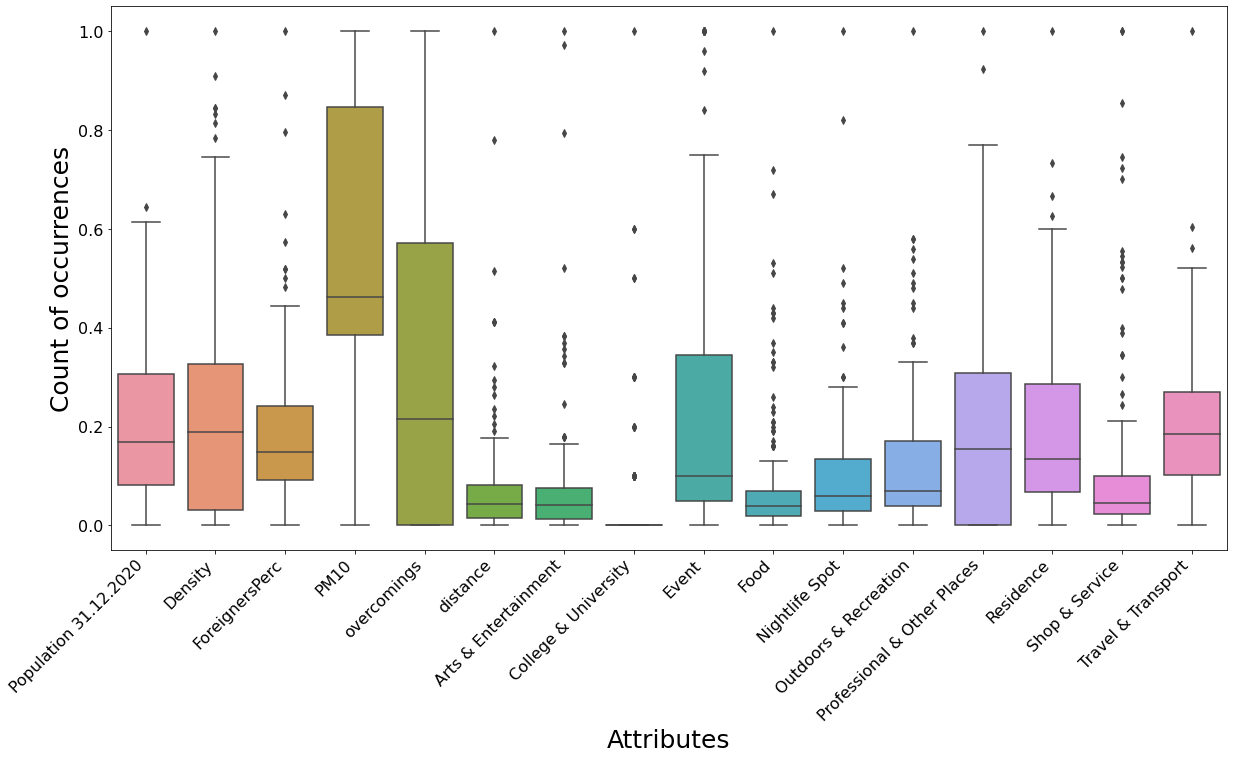

In [282]:
# plotting as before, but with scaled data using also population, density and percentage of foreigners
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = scaled_dataframe)
ax.set_ylabel('Count of occurrences', fontsize=25)
ax.set_xlabel('Attributes', fontsize=25)
ax.tick_params(labelsize=16)
plt.xticks(rotation=45, ha='right')

plt.show()


## K-Means Clustering

In [283]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [284]:

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(scaled_dataframe)
    kmeanModel.fit(scaled_dataframe)
 
    distortions.append(sum(np.min(cdist(scaled_dataframe, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / scaled_dataframe.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(scaled_dataframe, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / scaled_dataframe.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [285]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.718283383274574
2 : 0.617563926790115
3 : 0.5004522833359033
4 : 0.4490850041032653
5 : 0.42460321885580093
6 : 0.411645400618472
7 : 0.40955734947366434
8 : 0.3966284858294454
9 : 0.3844579180951638


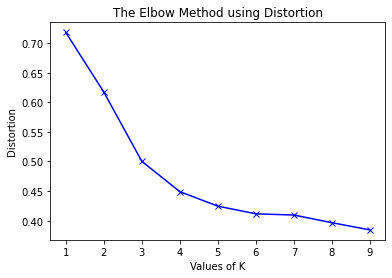

In [286]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [287]:
# number of clusters
clusters = 4

# performing the k-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(scaled_dataframe)

# retrieving the labels
kmeans_labels = kmeans.labels_

df_zones_clusters_labels = df_all.copy()
df_zones_clusters_labels['Cluster'] = kmeans_labels
zones_clusters_minmax_df = scaled_dataframe.copy()
zones_clusters_minmax_df['Cluster'] = kmeans_labels
zones_clusters_minmax_df['Name'] = df_all['Name']
zones_clusters_minmax_df['latitude'] = df_all['latitude']
zones_clusters_minmax_df['longitude'] = df_all['longitude']

## Results  <a name="Results"></a> 

Showing the characteristics of each cluster

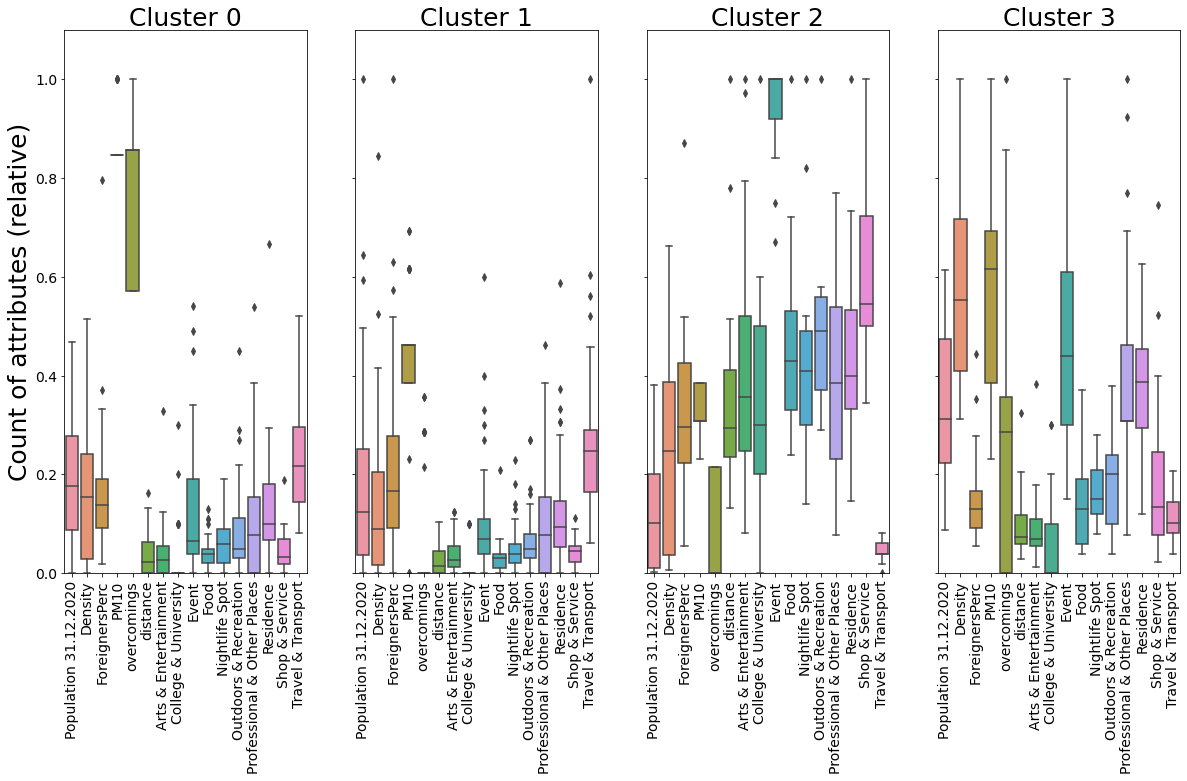

In [288]:
# importing ticker
import matplotlib.ticker as ticker

# creating a figure
fig, axes = plt.subplots(1,clusters, figsize=(20, 10), sharey=True)

# setting y label
axes[0].set_ylabel('Count of attributes (relative)', fontsize=25)

# building the boxes for each cluster
for k in range(clusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=14)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    # filling the box with boxplots
    sns.boxplot(data = zones_clusters_minmax_df[zones_clusters_minmax_df['Cluster'] == k].drop(['Cluster','latitude','longitude'],1), ax=axes[k])

plt.show()

The first cluster shows an excellent presence in all categories, while the second is significantly below. 
The third and fourth ones have smaller indicators and are differentiated mostly by distribution of venues
and population/pollution differences.

In [291]:
# saving results to excel
df_zones_clusters_labels.to_excel(r'zones_labeled.xlsx')

In [292]:
#loading labeled stations from the excel

# source filepath
filepath = "zones_labeled.xlsx"

# populating the dataframe
df_zones = pd.read_excel(filepath)
df_zones = df_zones.drop('Unnamed: 0', axis=1)
df_zones.head(200)

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,3,100,100,100,100,8,75,77,0.001,2
1,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,2,100,72,82,49,3,21,43,0.010,2
2,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,3,67,26,41,58,1,11,48,0.020,2
3,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,1,100,33,28,32,6,31,47,0.020,3
4,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,10,100,67,36,56,7,55,90,0.030,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,2,0,0,2,0,3,1,0.130,1
151,20M,Labaro,"Labaro, Prima Porta, Valle Muricana",15,21906,21730,11.67,1862,4513,21,...,0,5,2,6,3,0,9,2,0.090,1
152,20N,Cesano,"Olgiata, Giustiniana",15,10890,10910,41.33,264,2659,24,...,0,4,0,1,2,0,6,2,0.220,1
153,20O,Martignano,"Olgiata, Giustiniana",15,48,52,10.98,5,30,58,...,0,1,0,2,0,0,0,0,0.290,1


Add Prices from the excel file prices.xlsx

In [293]:
#Get df_prices from the excel file

# source filepath
filepath = "prices.xlsx"

# populating the dataframe
df_prices = pd.read_excel(filepath)

df_prices

df_zones_prices=df_zones
df_zones_prices=pd.merge(df_zones, df_prices, on=['Zona Immobiliare','Zona Immobiliare'])
df_zones_prices


,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster,PurchasePrice/sqm,RentalPrice/sqm
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,100,100,100,8,75,77,0.001,2,7406,20.3
1,01F,XX Settembre,Centro Storico,1,8846,8796,1.40,6283,1772,20,...,53,45,54,5,45,90,0.020,2,7406,20.3
2,01G,Celio,Centro Storico,1,3894,3857,0.68,5672,631,16,...,51,44,48,10,25,49,0.020,2,7406,20.3
3,01X,Zona Archeologica,Centro Storico,1,734,763,1.91,399,391,51,...,33,52,58,5,15,50,0.020,2,7406,20.3
4,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,72,82,49,3,21,43,0.010,2,5396,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20E,Grotta Rossa Ovest,"Cassia, San Godenzo, Grottarossa",15,2616,2677,10.88,246,814,30,...,1,4,4,5,5,2,0.070,1,2930,13.0
151,20F,Grotta Rossa Est,"Cassia, San Godenzo, Grottarossa",15,1278,1284,2.90,443,250,19,...,3,4,5,0,8,5,0.090,1,2930,13.0
152,20I,S. Cornelia,"Labaro, Prima Porta, Valle Muricana",15,9042,9064,34.26,265,1398,15,...,0,2,3,0,1,0,0.120,1,2047,10.2
153,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,2,0,3,1,0.130,1,2047,10.2


In [294]:
# Find the average house price for each cluster
df_zones_prices_grouped_averaged=df_zones_prices.groupby("Cluster")["PurchasePrice/sqm"].mean()
df_zones_prices_grouped_averaged

Cluster
0    2786.272727
1    2782.420290
2    5467.307692
3    3757.896552
Name: PurchasePrice/sqm, dtype: float64

In [304]:
df_zones_prices_grouped_counted=df_zones_prices.groupby("Cluster")["Name"].count()
df_zones_prices_grouped_counted

Cluster
0    44
1    69
2    13
3    29
Name: Name, dtype: int64

In [301]:
# Compare PM10 levels between clusters
df_zones_prices_grouped_pm10=df_zones_prices.groupby("Cluster")["PM10"].mean()
df_zones_prices_grouped_pm10

Cluster
0    30.363636
1    24.913043
2    23.384615
3    26.379310
Name: PM10, dtype: float64

In [302]:
# Compare overcomings between clusters
df_zones_prices_grouped_overcomings=df_zones_prices.groupby("Cluster")["overcomings"].mean()
df_zones_prices_grouped_overcomings

Cluster
0    15.000000
1     4.710145
2     5.153846
3     8.137931
Name: overcomings, dtype: float64

In [303]:
# Compare shops between clusters
df_zones_prices_grouped_shops=df_zones_prices.groupby("Cluster")["Shop & Service"].mean()
df_zones_prices_grouped_shops

Cluster
0    10.272727
1     8.652174
2    34.000000
3    27.965517
Name: Shop & Service, dtype: float64

In [305]:
# Compare distance between clusters
df_zones_prices_grouped_distance=df_zones_prices.groupby("Cluster")["distance"].mean()
df_zones_prices_grouped_distance

Cluster
0    0.115227
1    0.123188
2    0.023923
3    0.054483
Name: distance, dtype: float64

In [306]:
# Compare density between clusters
df_zones_prices_grouped_density=df_zones_prices.groupby("Cluster")["Density"].mean()
df_zones_prices_grouped_density

Cluster
0     4206.318182
1     3275.840580
2     6495.538462
3    14653.241379
Name: Density, dtype: float64

In [309]:
# Compare population between clusters
df_zones_prices_grouped_population=df_zones_prices.groupby("Cluster")["Population 31.12.2020"].mean()
df_zones_prices_grouped_population

Cluster
0    16085.431818
1    15086.608696
2    11144.153846
3    30150.137931
Name: Population 31.12.2020, dtype: float64

In [308]:
# Compare foreigners between clusters
df_zones_prices_grouped_foreigners=df_zones_prices.groupby("Cluster")["ForeignersPerc"].mean()
df_zones_prices_grouped_foreigners

Cluster
0    12.431818
1    15.420290
2    22.230769
3    12.517241
Name: ForeignersPerc, dtype: float64

In [296]:
zones_cluster_2=df_zones_prices.loc[df_zones_prices['Cluster'] == 2]
zones_cluster_2

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster,PurchasePrice/sqm,RentalPrice/sqm
0,01A,Centro Storico,Centro Storico,1,24166,23693,3.19,7427,6289,27,...,100,100,100,8,75,77,0.001,2,7406,20.3
1,01F,XX Settembre,Centro Storico,1,8846,8796,1.40,6283,1772,20,...,53,45,54,5,45,90,0.020,2,7406,20.3
2,01G,Celio,Centro Storico,1,3894,3857,0.68,5672,631,16,...,51,44,48,10,25,49,0.020,2,7406,20.3
3,01X,Zona Archeologica,Centro Storico,1,734,763,1.91,399,391,51,...,33,52,58,5,15,50,0.020,2,7406,20.3
4,01B,Trastevere,"Testaccio, Trastevere",1,13648,13447,1.81,7429,3824,28,...,72,82,49,3,21,43,0.010,2,5396,17.5
6,01C,Aventino,"Aventino, San Saba, Caracalla",1,8287,8251,1.56,5289,1714,21,...,26,41,58,1,11,48,0.020,2,6295,19.4
7,01E,Esquilino,"Termini, Repubblica",1,33463,33017,3.09,10685,8579,26,...,67,36,56,7,55,90,0.030,2,4053,16.3
8,17A,Prati,"Prati, Borgo, Mazzini, Delle Vittorie",1,17573,17381,1.76,9876,2174,13,...,42,49,51,4,40,48,0.020,2,4985,16.4
14,02X,Villa Borghese,"Parioli, Flaminio",2,625,617,1.40,441,195,32,...,32,41,37,2,34,63,0.020,2,5380,16.8
16,02D,Salario,"Salario, Trieste",2,25293,25116,1.93,13013,3354,13,...,24,30,31,7,29,31,0.030,2,4701,15.4


In [297]:
zones_cluster_3=df_zones_prices.loc[df_zones_prices['Cluster'] == 3]
zones_cluster_3

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster,PurchasePrice/sqm,RentalPrice/sqm
5,01D,Testaccio,"Testaccio, Trastevere",1,7834,7671,0.65,11802,717,9,...,33,28,32,6,31,47,0.02,3,5396,17.5
9,17B,Della Vittoria,"Prati, Borgo, Mazzini, Delle Vittorie",1,25443,25151,3.16,7959,2262,9,...,17,13,24,2,22,35,0.03,3,4985,16.4
12,02B,Parioli,"Parioli, Flaminio",2,21781,21567,2.07,10419,4175,19,...,8,22,25,6,23,22,0.03,3,5380,16.8
13,02C,Flaminio,"Parioli, Flaminio",2,13026,12860,1.39,9252,1197,9,...,13,21,37,2,22,14,0.03,3,5380,16.8
17,02E,Trieste,"Salario, Trieste",2,52747,52076,2.91,17896,5749,11,...,16,27,24,2,38,10,0.05,3,4701,15.4
18,03A,Nomentano,"Bologna, Policlinico",2,38678,38400,2.91,13196,3843,10,...,19,23,23,6,30,67,0.05,3,4365,15.1
23,06A,Torpignattara,"Pigneto, San Lorenzo, Casal Bertone",5,47616,47029,2.27,20718,10730,23,...,35,17,18,2,35,24,0.06,3,3138,14.0
24,04A,Monte Sacro,"Talenti, Monte Sacro, Nuovo Salario",3,16418,16132,1.65,9777,1872,12,...,16,12,9,5,18,7,0.07,3,3280,12.5
25,04B,Val Melaina,"Talenti, Monte Sacro, Nuovo Salario",3,36560,36207,3.20,11315,2920,8,...,6,8,4,4,13,4,0.07,3,3280,12.5
26,04C,Monte Sacro Alto,"Talenti, Monte Sacro, Nuovo Salario",3,33675,33466,2.48,13494,2403,7,...,6,11,11,1,32,11,0.09,3,3280,12.5


In [298]:
zones_cluster_1=df_zones_prices.loc[df_zones_prices['Cluster'] == 1]
zones_cluster_1

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster,PurchasePrice/sqm,RentalPrice/sqm
10,17C,Eroi,"Prati, Borgo, Mazzini, Delle Vittorie",1,19225,18917,0.88,21497,2238,12,...,2,2,0,1,5,4,0.48,1,4985,16.4
11,02A,Villaggio Olimpico,"Parioli, Flaminio",2,2833,2796,1.15,2431,238,9,...,21,23,27,1,23,6,0.03,1,5380,16.8
15,02Y,Villa Ada,"Parioli, Flaminio",2,848,849,2.88,295,133,16,...,2,18,8,1,4,7,0.04,1,5380,16.8
30,04D,Fidene,"Porta di Roma, Casal Boccone",3,11799,11615,1.10,10559,2092,18,...,0,3,6,1,3,4,0.08,1,3021,12.5
31,04E,Serpentara,"Porta di Roma, Casal Boccone",3,31867,31648,5.60,5651,1465,5,...,3,4,3,3,4,6,0.08,1,3021,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,20E,Grotta Rossa Ovest,"Cassia, San Godenzo, Grottarossa",15,2616,2677,10.88,246,814,30,...,1,4,4,5,5,2,0.07,1,2930,13.0
151,20F,Grotta Rossa Est,"Cassia, San Godenzo, Grottarossa",15,1278,1284,2.90,443,250,19,...,3,4,5,0,8,5,0.09,1,2930,13.0
152,20I,S. Cornelia,"Labaro, Prima Porta, Valle Muricana",15,9042,9064,34.26,265,1398,15,...,0,2,3,0,1,0,0.12,1,2047,10.2
153,20L,Prima Porta,"Labaro, Prima Porta, Valle Muricana",15,3707,3739,30.91,121,391,10,...,0,0,2,0,3,1,0.13,1,2047,10.2


In [299]:
zones_cluster_0=df_zones_prices.loc[df_zones_prices['Cluster'] == 0]
zones_cluster_0

,Zone,Name,Zona Immobiliare,District,Population 31.12.2019,Population 31.12.2020,Area,Density,Foreigners 31.12.2020,ForeignersPerc,...,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,distance,Cluster,PurchasePrice/sqm,RentalPrice/sqm
22,05A,Casal Bertone,"Pigneto, San Lorenzo, Casal Bertone",4,15864,15770,1.32,11947,1711,11,...,11,6,8,5,22,17,0.06,0,3138,14.0
41,05B,Casal Bruciato,"Monti Tiburtini, Pietralata",4,21180,21026,2.53,8311,1542,7,...,7,6,16,7,20,5,0.07,0,2939,12.3
42,05C,Tiburtino Nord,"Monti Tiburtini, Pietralata",4,19411,19404,3.53,5497,1774,9,...,4,7,7,5,9,8,0.08,0,2939,12.3
43,05D,Tiburtino Sud,"Monti Tiburtini, Pietralata",4,22779,22599,2.80,8071,1315,6,...,3,3,10,0,7,0,0.10,0,2939,12.3
44,05G,Pietralata,"Monti Tiburtini, Pietralata",4,13255,13197,2.23,5918,1860,14,...,10,11,12,3,6,9,0.06,0,2939,12.3
46,05F,Tor Cervara,"Ponte Mammolo, San Basilio, Tor Cervara",4,2908,2816,3.64,774,379,13,...,2,2,1,0,8,1,0.11,0,2503,12.0
54,07C,Tor Sapienza,"Alessandrino, Tor Sapienza, Torre Maura",5,12392,12306,2.15,5724,1883,15,...,3,4,3,0,5,3,0.11,0,2311,11.2
58,07H,Omo,"Alessandrino, Tor Sapienza, Torre Maura",5,1981,1971,2.81,701,465,24,...,0,2,4,1,13,6,0.13,0,2311,11.2
82,11E,Tormarancia,"Appia Pignatelli, Ardeatino, Montagnola",8,33026,32912,4.75,6929,3541,11,...,5,13,22,2,18,5,0.05,0,3451,12.4
83,11G,Grottaperfetta,"Appia Pignatelli, Ardeatino, Montagnola",8,15636,15556,2.96,5255,852,5,...,4,4,12,0,18,4,0.08,0,3451,12.4


Showing the map with cluster classification

In [322]:
# Rome coordinates

latitude = 41.9028
longitude = 12.4964

# creating map
map_zones = folium.Map(location=[latitude, longitude], zoom_start=9)

# setting color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = ["darkblue","firebrick","orange","dodgerblue"]
# adding markers to the map
markers_colors = []
for lat, lon, poi, categoria in zip(df_zones_prices['latitude' ], df_zones_prices['longitude'], df_zones_prices['Name'], df_zones_prices['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(categoria), parse_html=True)
    if math.isnan(categoria): categoria=5
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, 
        color=rainbow[int(categoria-1)],
        fill=True,
        fill_color=rainbow[int(categoria-1)],
        fill_opacity=0.7).add_to(map_zones)
map_zones
 

## Discussion <a name="Discussion"></a>

The visual analysis of the clusters (see boxplots above) and the comparison of the mean values of features for all clusters showed the first two clusters having similar distributions, with Cluster 1 denoting slightly lower values for all features but the percentage of foreign-born residents. The only significant difference between Clusters 0 and 1, in addition to the percentage of foreign-born residents, seems to be air pollution: the neighborhoods in Cluster 0 had higher levels of PM10 and more days with PM10 level exceeding the safety threshold of 50 μg/m3. 
Clusters 2 and 3 present definitely higher values for almost all examined features, than the first two clusters. The density of population is much higher in these neighborhoods, with the mean of 6496 residents/square km for Cluster 2 and 14653 for Cluster 3. There are also more venues in all categories, especially in Cluster 2. Also, Cluster 2 neighborhoods have better air quality and a higher mean percentage of foreigners (22,2% compared with 12,5% for Cluster 3, 12,4% for Cluster 0 and 15,4% for Cluster 1).

The K-Means algorithm applied to our dataset divided Rome's neighborhoods into 4 clusters as described in the Results section. The mean house price per square meter was very similar for the first two clusters, 2786 euros for Cluster 0 and 2782 for Cluster 1. The average prices increase significantly for Cluster 3 (3758 euro/sqm), and even more for Cluster 2 (5467 euro/sqm).
Hence, we can observe that the highest house prices per square meter can be found in the neighborhoods of the strict center of the city that form Cluster 2. The mid-range prices can be found in the neighborhoods adjacent the city center that form Cluster 3. Finally, the lowest house price averages belong to clusters 0 and 1, whose neighborhoods are located further away from the city center. 
Therefore, notwithstanding the fact that FourSquare data is unbalanced, with some categories, such as food, over-represented, the clustering made quite sense, with the neighborhood distribution matching broadly the price ranges given at www.immobiliare.it, as shown on the maps below. We can see that the areas marked in red and yellow roughly correspond to each other and that the areas marked in blue on our map (both light and dark blue) correspond to the areas colored green on the web-sourced pricing map. In fact, the mean house price for the two blue clusters is very similar. This means that some of their features balance each other, leading to similar pricing.

## Conclusion <a name="Conclusion"></a>

The goal of the project was to use data gathered from FourSquare (free developer account) and other open sources to cluster the neighborhoods in Rome and understand in what way the characteristics of each area affect house prices.

The clustering model showed that house prices depend on the density of population, the traffic (air pollution), the presence of venues as shops, restaurants, cinemas etc. and the distance from the city center. Observing all the discussed indicators and their trends over time could greatly enhance property valuation and help investors predict in which neighborhoods the prices are likely to increase and in which to decrease.

To make the model more accurate, some other features could be added, like public transport availability, income statistics or crime statistics.
An interesting development would be also the use of Google Street View images and deep learning models for image recognition to assess the structural condition of buildings in each area.